In [1]:
library(tidyr)
library(dplyr)
library(ggplot2)
library(readr)
library(forcats)
library(ggnewscale)
library(stringr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Load clinical data
clini <- read_csv("../../data/summary_clinical_data_modified.csv", na = c("", "NA", "NaN"))
# List profiled FOVs
profiled_fovs <- unique(read_csv("../../data/cell_table_with_types_stage.csv")$fov)
clini <- clini %>% filter(`TMA Localisation` %in% profiled_fovs)

Rows: 522 Columns: 31
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (26): TMA name, TMA sector, TMA Localisation, Tumorlokalisation COL10, T...
dbl  (3): Tumordurchmesser (mm), Age, Tumor Size Group
lgl  (2): Grade raw, pM group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 579011 Columns: 70
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (31): fov, annotation_t, annotation_scyan, consensus, annotation_consens...
dbl (37): ...1, CA9, nuclei, CD98, CytC, MSH2, MCT1, PDL1, PD1, ASCT2, LDH, ...
lgl  (2): Grade raw, pM group

ℹ Use `spec()` to retrieve the full column specification for this data

In [3]:
# Create ordered pT groups and reorder TMA locations
clini <- clini %>%
  mutate(`pT group` = factor(`pT group`, 
                            levels = c("pT1", "pT2", "pT3", "pT4"),
                            ordered = TRUE)) %>%
  # Get TMA locations in pT group order
  arrange(`pT group`) %>%
  mutate(`TMA Localisation` = factor(`TMA Localisation`, 
                                    levels = unique(`TMA Localisation`),
                                    ordered = TRUE))

In [4]:
profiled_fovs  %>% length()

[1] 469

In [5]:
clini %>% select(`TMA Localisation`) %>% unique() %>% nrow()

[1] 458

In [6]:
table(clini %>% select("RAS Mutation RED"))

RAS Mutation RED
codon 117  codon 12  codon 13 codon 146  codon 61        wt 
        1       134        31         2        10       234 

In [7]:
table(clini %>% select('BRAF Mutation RED'))

BRAF Mutation RED
BRAF V600E         wt 
         7          8 

In [8]:
# Equivalent to clini.isna().sum()
is.na(clini) %>% colSums()

TMA name                             TMA sector 
                                     0                                      0 
                      TMA Localisation                Tumorlokalisation COL10 
                                     0                                      0 
            Tumorlokalisation alle RED                       Tumor Seite alle 
                                     3                                      4 
                              Tumortyp                                 pT raw 
                                     0                                      7 
                                pN raw                              Grade raw 
                                     9                                    458 
                              pT group                               pN group 
                                     8                                      9 
                              pM group                  Tumordurchmesser (mm) 
                                   458                                     17 
              Muzinöse Tumorkomponente                       Infiltrationstyp 
                                   188                                    115 
                          Tumorbudding Peritumorale lymphozytäre Infiltration 
                                   158                                    133 
                   Angioinvasion V RED                    Lymphbahninvasion L 
                                    10                                     34 
                         MSI im Befund                         MSI gesamt RED 
                                   282                                     98 
                      RAS Mutation RED                     RAS Mutation RED 2 
                                    46                                     46 
                     BRAF Mutation RED                     HER2 Amplifikation 
                                   443                                     52 
                                   Age                                    Sex 
                                     1                                      0 
                                  MIBI                       Tumor Size Group 
                                     0                                     18 
                             Age Group 
                                     1

In [9]:
# Define bins based on thirds for age and tumor size
size_bins = clini %>% select(`Tumordurchmesser (mm)`) %>% quantile(probs = c(0, 1/3, 2/3, 1), na.rm = TRUE)
age_bins = clini %>% select(`Age`) %>% quantile(probs = c(0, 1/3, 2/3, 1), na.rm = TRUE)

# Refactor data
clini <- clini %>%
  mutate(
    `MS status` = case_when(
      `MSI gesamt RED` == "stabil" ~ "MSS",
      `MSI gesamt RED` == "instabil" ~ "MSI",
      TRUE ~ NA_character_
    ),
    pT = str_remove(`pT group`, "^p"),
    pN = case_when(
    str_detect(`pN raw`, "pN0") ~ "N0",
    str_detect(`pN raw`, "pN1") ~ "N1", 
    str_detect(`pN raw`, "pN2") ~ "N2",
    TRUE ~ NA_character_
    ),
    `Tumor size` = case_when(
      `Tumordurchmesser (mm)` <= size_bins[2] ~ "Small [8-35 mm]",
      `Tumordurchmesser (mm)` <= size_bins[3] ~ "Medium [36-51 mm]",
      `Tumordurchmesser (mm)` <= size_bins[4] ~ "Large [52-145 mm]",
      TRUE ~ NA_character_
    ),
    `Age bins` = case_when(
      Age <= age_bins[2] ~ "[18-66]",
      Age <= age_bins[3] ~ "[67-77]",
      Age <= age_bins[4] ~ "[78-99]",
      TRUE ~ NA_character_
    ),
    `Tumor side` = case_when(
      `Tumor Seite alle` == "rechts" ~ "Right",
      `Tumor Seite alle` == "links" ~ "Left",
      TRUE ~ NA_character_
    ),
    `Tumor location` = case_when(
      `Tumorlokalisation alle RED` == "Ascendens" ~ "Ascending",
      `Tumorlokalisation alle RED` == "Descendens" ~ "Descending",
      `Tumorlokalisation alle RED` == "Rektum" ~ "Rectum",
      `Tumorlokalisation alle RED` == "Sigma" ~ "Sigmoid",
      `Tumorlokalisation alle RED` == "Transversum" ~ "Transverse",
      `Tumorlokalisation alle RED` == "Zoekum" ~ "Cecum",
      TRUE ~ NA_character_
    ),
    `RAS mutation` = case_when(
      `RAS Mutation RED 2` == "wt" ~ "WT",
      `RAS Mutation RED 2` == "RAS Mut." ~ "Mutant",
      TRUE ~ NA_character_
    ),
    `HER amplification` = case_when(
      `HER2 Amplifikation` == "nein" ~ "Negative",
      `HER2 Amplifikation` == "ja" ~ "Positive",
      TRUE ~ NA_character_
    ),
    `Sex2` = case_when(
      `Sex` == "m" ~ "Man",
      `Sex` == "w" ~ "Woman",
    )
  )
# Also redefine bins for age and tumor size to thirds

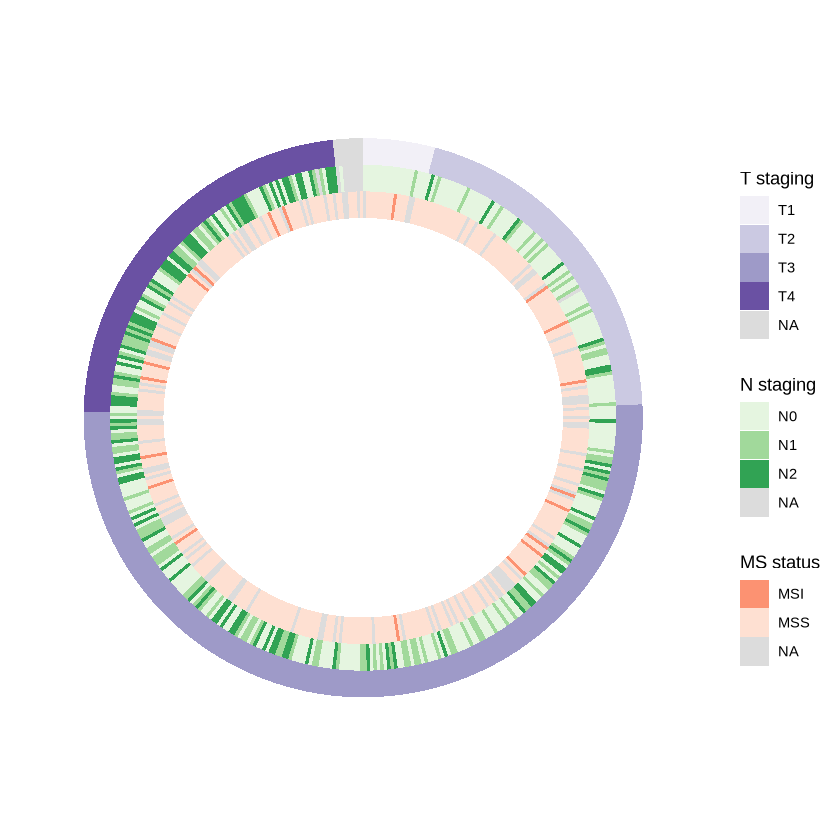

In [10]:
gp <- ggplot(clini, aes(x = `TMA Localisation`)) +
  geom_tile(aes(fill = `MS status`, y = 1)) +
  scale_fill_brewer(name = "MS status", 
    palette = "Reds",
    direction = -1,
    na.value = "#dcdcdc",
    guide = guide_legend(order = 3)) +
  new_scale_fill() +
  geom_tile(aes(fill = `pN`, y = 2)) +
  scale_fill_brewer(name = "N staging", 
    palette = "Greens",
    na.value = "#dcdcdc",
    guide = guide_legend(order = 2)) +
  new_scale_fill() +
  scale_fill_brewer(name = "T staging", 
    palette = "Purples",
    na.value = "#dcdcdc",
    guide = guide_legend(order = 1)) +
  geom_tile(aes(fill = `pT`, y = 3)) +
  ylim(-7,3.5) +
  coord_polar() +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    panel.grid.major = element_blank(),  # Remove major grid
  )     

  ggsave("../../figures/fig1/clinical_data_circular.pdf", plot = gp, width = 6.5, height = 6.5, dpi = 300)
  gp

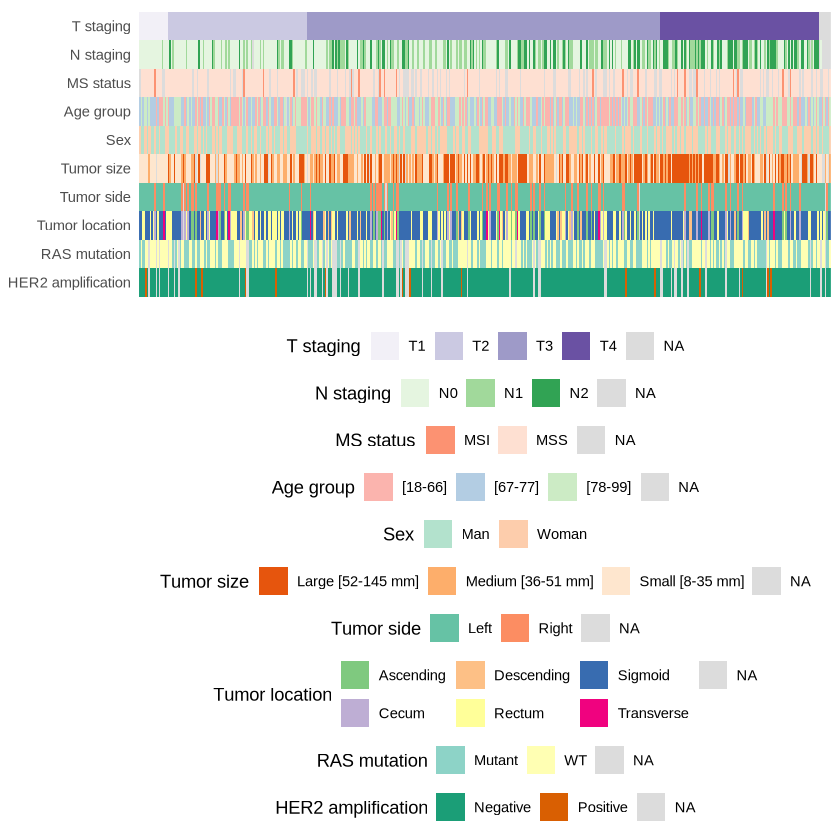

In [11]:
# Define variable specifications
var_specs <- data.frame(
  var_name = c("T staging", "N staging", "MS status", "Age group", "Sex",
               "Tumor size", "Tumor side", "Tumor location", 
               "RAS mutation", "HER2 amplification"),
  col_name = c("pT", "pN", "MS status", "Age bins", "Sex2",
               "Tumor size", "Tumor side", "Tumor location",
               "RAS mutation", "HER amplification"),
  palette = c("Purples", "Greens", "Reds", "Pastel1", "Pastel2",
              "Oranges", "Set2", "Accent", "Set3", "Dark2"),
  palette_dir = 1 
)
var_specs$row_position <- nrow(var_specs):1 # Reverse order for plotting from top to bottom,
var_specs$palette_dir[3] <- -1
var_specs$palette_dir[6] <- -1

# Helper function with ordered factors
add_variable_layers <- function(plot, var_spec) {
  plot +
    new_scale_fill() +
    geom_tile(aes(fill = .data[[var_spec$col_name]], 
                  y = factor(var_spec$var_name,
                           levels = var_specs$var_name[order(var_specs$row_position)]))) +
    scale_fill_brewer(name = var_spec$var_name,
                     palette = var_spec$palette,
                     na.value = "#dcdcdc",
                     direction = var_spec$palette_dir,
                     guide = guide_legend(order = 100 - var_spec$row_position))
}

# Create base plot
gp <- ggplot(clini, aes(x = `TMA Localisation`))

# Add layers in order of row_position
var_specs_ordered <- var_specs[order(var_specs$row_position), ]
for(i in 1:nrow(var_specs_ordered)) {
  gp <- add_variable_layers(gp, var_specs_ordered[i,])
}

# Add theme and guides with ordered legends
gp <- gp +
  theme_minimal() +
  theme(
    axis.text.x = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    panel.grid.major = element_blank(),
    legend.position = "bottom",
    legend.box = "vertical",
    legend.spacing = unit(0, "cm")
  ) 

ggsave("../../figures/fig1/clinical_data_heatmap.pdf", 
       plot = gp, width = 13, height = 6.5, dpi = 300)
gp